In [2]:
from datamarket import *

# Read the data and train model without augmentation
We first use factorized linear regression, then automl.

In summary, R2 score for linear regression is:0.009878592245889273, for automl is: 0.5458767724247864

In [151]:
# read buyer dataset
# gender 
# buyer = pd.read_csv("gender.csv")
# ethnic 
# buyer = pd.read_csv("2013-2017_School_ELA_Results_-_Ethnic.csv")
# survery
buyer = pd.read_csv("NH_SurveySummary_Mar2022.csv", encoding='cp1252')

# buyer = pd.read_csv("NH_CovidVaxProvider_20220320.csv", encoding='cp1252')

# train test split
msk = split_mask(len(buyer)) < 0.8
buyer_train = buyer[msk].copy()
buyer_test = buyer[~msk].copy()

In [152]:
buyer

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Inspection Cycle,Health Survey Date,Fire Safety Survey Date,Total Number of Health Deficiencies,...,Count of Interior Deficiencies,Count of Gas and Vacuum and Electrical Systems Deficiencies,Count of Hazardous Area Deficiencies,Count of Illumination and Emergency Power Deficiencies,Count of Laboratories Deficiencies,Count of Medical Gases and Anaesthetizing Areas Deficiencies,Count of Smoking Regulations Deficiencies,Count of Miscellaneous Deficiencies,Location,Processing Date
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,1,2019-08-21,2019-08-21,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2022-03-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2,2018-08-01,2018-08-09,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2022-03-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,3,2017-06-22,2017-06-29,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2022-03-01
3,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,1,2019-06-13,2019-06-18,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2022-03-01
4,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,2,2018-06-07,2018-06-11,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2022-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45255,686124,HARMONY HEALTH CENTER,9820 N KENDALL DRIVE,MIAMI,FL,33176,1,2021-02-12,2021-02-16,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"9820 N KENDALL DRIVE,MIAMI,FL,33176",2022-03-01
45256,686124,HARMONY HEALTH CENTER,9820 N KENDALL DRIVE,MIAMI,FL,33176,2,2019-05-17,2019-05-15,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"9820 N KENDALL DRIVE,MIAMI,FL,33176",2022-03-01
45257,745000,LAS ALTURAS DE PENITAS,414 LIBERTY BLVD.,PENITAS,TX,78576,1,2021-07-08,2021-07-08,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"414 LIBERTY BLVD.,PENITAS,TX,78576",2022-03-01
45258,745001,ESTATES AT SHAVANO PARK,4366 LOCKHILL SELMA,SHAVANO PARK,TX,78249,1,2021-07-16,2021-07-16,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"4366 LOCKHILL SELMA,SHAVANO PARK,TX,78249",2022-03-01


In [153]:
buyer_train_data = agg_dataset()
buyer_train_data.load(buyer_train, ['Total Number of Health Deficiencies','Total Number of Fire Safety Deficiencies'], ["Federal Provider Number", 'Location', 'Processing Date'], "buyer")
buyer_train_data.process_target('Total Number of Health Deficiencies')
# buyer_train_data.load(buyer_train, ['Percent Vaccinated Residents'], ["Federal Provider Number", 'Provider State'], "buyer")
# buyer_train_data.process_target('Percent Vaccinated Residents')

buyer_train_data.to_numeric_and_impute_all()
buyer_train_data.remove_redundant_columns()
buyer_train_data.compute_agg()

buyer_test_data = agg_dataset()
buyer_test_data.load(buyer_test, ['Total Number of Health Deficiencies','Total Number of Fire Safety Deficiencies'], ["Federal Provider Number", 'Location', 'Processing Date'], "buyer")
buyer_test_data.process_target('Total Number of Health Deficiencies')
# buyer_test_data.load(buyer_test, ['Percent Vaccinated Residents'], ["Federal Provider Number", 'Provider State'], "buyer")
# buyer_test_data.process_target('Percent Vaccinated Residents')
buyer_test_data.to_numeric_and_impute_all()
buyer_test_data.remove_redundant_columns()
buyer_test_data.compute_agg()

In [154]:
# model performance before augmentation with linear regression
train_cov = buyer_train_data.covariance
test_cov = buyer_test_data.covariance
# x = ['buyer:Number Tested']
# y = 'buyer:Mean Scale Score'

X = ['Total Number of Fire Safety Deficiencies']
y = 'Total Number of Health Deficiencies'

# X = []
# y = 'Percent Vaccinated Residents'

parameter = linear_regression(train_cov, ["buyer:" + x for x in X], "buyer:" + y)
print("R2 score is:" + str(r2(test_cov, ["buyer:" + x for x in X], "buyer:" + y, parameter)))

R2 score is:0.053929447316620194


In [161]:
# categories = ['DBN', 'Year', "Grade", "Category"]
categories = ["Federal Provider Number", 'Location', 'Processing Date']
# categories = ["Federal Provider Number", 'Provider State']
for cate in categories:
    buyer = buyer.astype({cate: 'category'})

buyer[y] = pd.to_numeric(buyer[y], errors='coerce')
buyer.dropna(subset=[y],inplace=True)
msk = split_mask(len(buyer)) < 0.8
buyer_train = buyer[msk].copy()
buyer_test = buyer[~msk].copy()

In [135]:
time_budget = 600

In [136]:
%%time
# model performance with autoML 
X_train = buyer_train[X + categories]
y_train = buyer_train[y]
X_test = buyer_test[X + categories]
y_test = buyer_test[y]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=time_budget,
    per_run_time_limit=int(time_budget/3),
    memory_limit=6072
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='buyer')

now_n = datetime.now()
current_time = now_n.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 01:15:17
CPU times: user 1.25 s, sys: 854 ms, total: 2.1 s
Wall time: 10min 2s


In [137]:
automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: buyer\n  Metric: r2\n  Best validation score: 0.119860\n  Number of target algorithm runs: 21\n  Number of successful target algorithm runs: 15\n  Number of crashed target algorithm runs: 2\n  Number of target algorithms that exceeded the time limit: 3\n  Number of target algorithms that exceeded the memory limit: 1\n'

Train R2 score: 0.10989946814293938
Test R2 score: 0.1251683564703593
          rank  ensemble_weight               type      cost  duration
model_id                                                              
4            1             0.52        extra_trees  0.880140  7.538252
19           2             0.48  gradient_boosting  0.880196  3.876652
                    Timestamp  ensemble_optimization_score  \
12 2022-04-04 01:05:30.000000                          NaN   
0  2022-04-04 01:05:30.449448                     0.096048   
13 2022-04-04 01:05:34.000000                     0.096048   
1  2022-04-04 01:05:34.134392                     0.107126   
14 2022-04-04 01:05:41.000000                     0.107126   
24 2022-04-04 01:05:41.000000                     0.107126   
23 2022-04-04 01:05:41.000000                     0.107126   
22 2022-04-04 01:05:41.000000                     0.107126   
21 2022-04-04 01:05:41.000000                     0.107126   
20 2022-04-04 01:05:41.000

<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

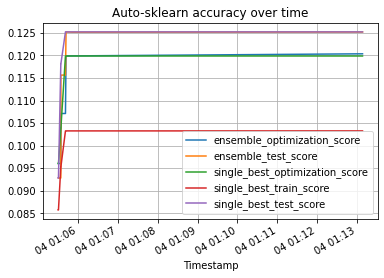

In [138]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [139]:
poT1 = automl.performance_over_time_

In [140]:
poT1 = automl.performance_over_time_
poT1["duration"] = [t.total_seconds() + time_budget for t in(poT1["Timestamp"] - now_n)]
# poT1[["ensemble_test_score", "duration"]]
poT1.fillna(0, inplace=True)
poT1[["ensemble_test_score", "duration"]].to_csv("automl_naive_vax.csv",index=False)

In [167]:
market_time = 30
poT2["duration"] = [t.total_seconds() + market_time + time_budget for t in(poT2["Timestamp"] - now_aug)]
poT2.fillna(0, inplace=True)
poT2[["ensemble_test_score", "duration"]].to_csv("automl_service_survey.csv",index=False)

In [ ]:
poT2

# Load seller datasets and build market
Currently, we need to specify the join attributes (could be joined on multiple attributes) and these attributes name have to be same across two tables.

We need more data.

The best data increase linear regression R2 to 0.3944023420421897

This data also increase automl R2 to: 0.7970338954417067

In [108]:
# read buyer dataste
crime = pd.read_csv("crime.csv")
crimedata = agg_dataset()
crimedata.load(crime, [], ["DBN"], "crime")
crimedata.find_features()
crimedata.remove_redundant_columns()
crimedata.compute_agg(True)


esl = pd.read_csv("esl.csv")
esldata = agg_dataset()
esldata.load(esl, [], [["DBN","Grade"]], "esl")
esldata.find_features()
esldata.remove_redundant_columns()
esldata.compute_agg(True)

ap = pd.read_csv("ap.csv")
apdata = agg_dataset()
apdata.load(ap, [], ["DBN"], "ap")
apdata.find_features()
apdata.remove_redundant_columns()
apdata.compute_agg(True)

survey = pd.read_csv("2013_NYC_School_Survey.csv")
surveydata = agg_dataset()
surveydata.load(survey, [], ["DBN"], "survey")
surveydata.find_features()
surveydata.remove_redundant_columns()
surveydata.compute_agg(True)

base = pd.read_csv("base.csv")
basedata = agg_dataset()
basedata.load(base, [], ["DBN"], "base")
basedata.find_features()
basedata.remove_redundant_columns()
basedata.compute_agg(True)

disc = pd.read_csv("disc.csv")
discdata = agg_dataset()
discdata.load(disc, [], ["DBN"], "disc")
discdata.find_features()
discdata.remove_redundant_columns()
discdata.compute_agg(True)

math = pd.read_csv("math.csv")
mathdata = agg_dataset()
mathdata.load(math, [], [["DBN","Grade"]], "math")
mathdata.find_features()
mathdata.remove_redundant_columns()
mathdata.compute_agg(True)

oss = pd.read_csv("oss.csv")
ossdata = agg_dataset()
ossdata.load(oss, [], ["DBN"], "oss")
ossdata.find_features()
ossdata.remove_redundant_columns()
ossdata.compute_agg(True)

pe = pd.read_csv("pe.csv")
pedata = agg_dataset()
pedata.load(pe, [], ["DBN"], "pe")
pedata.find_features()
pedata.remove_redundant_columns()
pedata.compute_agg(True)

s2tr = pd.read_csv("s2tr.csv")
s2trdata = agg_dataset()
s2trdata.load(s2tr, [], ["DBN"], "s2tr")
s2trdata.find_features()
s2trdata.remove_redundant_columns()
s2trdata.compute_agg(True)

sat = pd.read_csv("sat.csv")
satdata = agg_dataset()
satdata.load(sat, [], ["DBN"], "sat")
satdata.find_features()
satdata.remove_redundant_columns()
satdata.compute_agg(True)

pro = pd.read_csv("Schools_Progress_Report_2012-2013.csv")
prodata = agg_dataset()
prodata.load(pro, [], ["DBN"], "pro")
prodata.find_features()
prodata.remove_redundant_columns()
prodata.compute_agg(True)


spy = pd.read_csv("spy.csv")
spydata = agg_dataset()
spydata.load(spy, [], ["Year"], "spy")
spydata.find_features()
spydata.remove_redundant_columns()
spydata.compute_agg(True)

transfer = pd.read_csv("transfer.csv")
transferdata = agg_dataset()
transferdata.load(transfer, [], ["DBN"], "transfer")
transferdata.find_features()
transferdata.remove_redundant_columns()
transferdata.compute_agg(True)

yabc = pd.read_csv("yabc.csv")
yabcdata = agg_dataset()
yabcdata.load(yabc, [], ["DBN"], "yabc")
yabcdata.find_features()
yabcdata.remove_redundant_columns()
yabcdata.compute_agg(True)

dm1 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.22rr-ujq3")
dm1data = agg_dataset()
dm1data.load(dm1, [], ["DBN"], "dm1")
dm1data.find_features()
dm1data.remove_redundant_columns()
dm1data.compute_agg(True)

dm2 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.25aa-q86c")
dm2data = agg_dataset()
dm2data.load(dm2, [], ["DBN"], "dm2")
dm2data.find_features()
dm2data.remove_redundant_columns()
dm2data.compute_agg(True)

dm3 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.29bv-qqsy")
dm3data = agg_dataset()
dm3data.load(dm3, [], ["DBN"], "dm3")
dm3data.find_features()
dm3data.remove_redundant_columns()
dm3data.compute_agg(True)

dm4 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.29ry-u5bf")
dm4data = agg_dataset()
dm4data.load(dm4, [], ["DBN"], "dm4")
dm4data.find_features()
dm4data.remove_redundant_columns()
dm4data.compute_agg(True)

dm5 = pd.read_csv("other/datamart.socrata.data-cityofnewyork-us.43qc-8vv8")
dm5data = agg_dataset()
dm5data.load(dm5, [], [["DBN","Grade"]], "dm5")
dm5data.find_features()
dm5data.remove_redundant_columns()
dm5data.compute_agg(True)

/home/jupyter/arda/arda-datasets/school/datamarket.py:201: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data['cov:Q:' + tablename + ":" + attributes[i] + ","+ tablename + ":" + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]


In [83]:
# provider = pd.read_csv("NH_ProviderInfo_Mar2022.csv",  encoding='cp1252')
# providerdata = agg_dataset()
# providerdata.load(provider, [], ["Federal Provider Number"], "provider")
# providerdata.find_features()
# providerdata.remove_redundant_columns()
# providerdata.create_count_true()
# providerdata.compute_agg(True)

# faclevel_2020 = pd.read_csv("faclevel2020.csv",  encoding='cp1252')
# facleveldata = agg_dataset()
# facleveldata.load(faclevel_2020, [], ["Federal Provider Number"], "faclevel")
# facleveldata.find_features()
# facleveldata.remove_redundant_columns()
# facleveldata.create_count_true()
# facleveldata.compute_agg(True)


# uscovid = pd.read_csv("covid-newcases_2021.csv")
# uscoviddata = agg_dataset()
# uscoviddata.load(uscovid, [], [["Week Ending", "Provider State"]], "uscovid")
# uscoviddata.find_features()
# uscoviddata.remove_redundant_columns()
# uscoviddata.create_count_true()
# uscoviddata.compute_agg(True)

# measure = pd.read_csv("measure_scale.csv")
# measuredata = agg_dataset()
# measuredata.load(measure, [], ["Measure Code"], "measure")
# measuredata.find_features()
# measuredata.remove_redundant_columns()
# measuredata.create_count_true()
# measuredata.compute_agg(True)


In [114]:
def select_features(train, test, seller, dimension, k, target, pca=False):
    join_test = connect(test, seller, dimension)
    join_train = connect(train, seller, dimension)

    cur_atts = []
    join_train_cov = join_train.sum()
    join_test_cov = join_test.sum()
    final_r2 = 0
    
    for i in range(k):
        best_r2 = 0
        best_att = -1
        for att in train.X + seller.X:
            if att in cur_atts or att == train.name + ":" + target:
                continue
            # maybe singular
            parameter = linear_regression(join_train_cov, cur_atts + [att], train.name + ":" + target)
            cur_r2 = r2(join_test_cov, cur_atts + [att], train.name + ":" + target, parameter)
    #         print(cur_r2, att)
            if cur_r2 > best_r2:
                best_r2 = cur_r2
                best_att = att
        if best_r2 == 0 or best_r2 < final_r2:
            break
        cur_atts = cur_atts + [best_att]
        final_r2 = best_r2
#         print(i, best_r2, cur_atts)
        
        # pca only pick one 
        if best_att in seller.X and pca:
            return cur_atts, final_r2
    return cur_atts, final_r2

In [155]:
%%time
# sellers = [(crimedata, "DBN"), (apdata, "DBN"), (surveydata, "DBN"), 
#            (basedata, "DBN"), (discdata, "DBN"), (mathdata, ("DBN","Grade")), 
#            (ossdata, "DBN"), (pedata, "DBN"), (s2trdata, "DBN"), 
#            (satdata, "DBN"), (prodata, "DBN"), (spydata, "Year"),
#            (transferdata, "DBN"), (yabcdata, "DBN"), (dm1data, "DBN"),
#            (dm2data, "DBN"), (dm3data, "DBN"), (dm4data, "DBN"), (dm5data, ("DBN","Grade"))]

# sellers = [(mathdata, ("DBN","Grade"))]
sellers = [(providerdata, "Federal Provider Number")]

# find m best datasets to augment
bought = set()
m = 1

for i in range(m):
    best_seller = None
    best_seller_attrs = []
    best_dimension = None
    best_r2 = 0

    for sellerdata, dimension in sellers:
        # check if current seller has been bought
        if sellerdata.name in buyer_train_data.datasets:
            continue
        print(sellerdata.name)

        # find the attributes and r2 of augmenting
        cur_atts, final_r2 = select_features(buyer_train_data, buyer_test_data, sellerdata, dimension, 6, y)
#         cur_atts, final_r2 = select_features(buyer_train, buyer_test, sellerdata, dimension,10)
        print(cur_atts, final_r2)
        if final_r2 > best_r2:
            best_seller = sellerdata
            best_dimension = dimension
            best_seller_attrs = cur_atts
            best_r2 = final_r2


    print(best_seller.name, best_seller_attrs, best_r2)
    
    if len([x for x in best_seller_attrs if x in best_seller.X]) == 0:
        buyer_train_data.datasets.add(best_seller)
        buyer_test_data.datasets.add(best_seller)
    else:
        buyer_train_data.absorb(best_seller, best_dimension, best_seller_attrs + [buyer_train_data.name + ":" + y])
        buyer_test_data.absorb(best_seller, best_dimension, best_seller_attrs + [buyer_train_data.name + ":" + y])

provider


/home/jupyter/arda/arda-datasets/school/datamarket.py:383: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  join.drop('cov:c_y', 1, inplace=True)
/home/jupyter/arda/arda-datasets/school/datamarket.py:416: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  join['cov:Q:' + att2 + "," + att1] = join['cov:s:' + att2] * join['cov:s:' + att1]


['provider:Rating Cycle 2 Number of Standard Health Deficiencies', 'provider:Rating Cycle 1 Number of Standard Health Deficiencies', 'provider:Rating Cycle 3 Number of Standard Health Deficiencies', 'buyer:Total Number of Fire Safety Deficiencies', 'provider:Provider Zip Code', 'provider:Total Number of Penalties'] 0.6474007127287299
provider ['provider:Rating Cycle 2 Number of Standard Health Deficiencies', 'provider:Rating Cycle 1 Number of Standard Health Deficiencies', 'provider:Rating Cycle 3 Number of Standard Health Deficiencies', 'buyer:Total Number of Fire Safety Deficiencies', 'provider:Provider Zip Code', 'provider:Total Number of Penalties'] 0.6474007127287299
CPU times: user 3.97 s, sys: 404 ms, total: 4.38 s
Wall time: 4.37 s


In [55]:
best_dimension = ['DBN', 'Grade']

In [156]:
# make best_dimension a list
if isinstance(best_dimension, tuple):
    best_dimension = list(best_dimension)
else:
    best_dimension = [best_dimension]

# extract needed attributes
seller_features = ['cov:s:' +  attr for attr in best_seller_attrs  if attr.startswith(best_seller.name)]
buyer_features = ['cov:s:' +  attr for attr in best_seller_attrs  if not attr.startswith(best_seller.name)]
target = ['cov:s:buyer:' + y]
buyer_train_data_df = buyer_train_data.data[buyer_train_data.dedup_dimensions + buyer_features + target]
buyer_test_data_df = buyer_test_data.data[buyer_train_data.dedup_dimensions + buyer_features + target]
seller_data = best_seller.data[best_dimension + seller_features]
# seller_data = seller_data.groupby(best_dimension).mean()

# join buyer and seller
join_train = pd.merge(buyer_train_data_df,seller_data,how='left', on=best_dimension)
join_test = pd.merge(buyer_test_data_df,seller_data,how='left', on=best_dimension)

In [162]:
for cate in categories:
    print(cate)
    join_train = join_train.astype({cate: 'category'})
    join_test = join_test.astype({cate: 'category'})

Federal Provider Number
Location
Processing Date


In [90]:
# from sklearn.preprocessing import LabelEncoder
# # Create encoder
# le = LabelEncoder()
# join_train["Federal Provider Number"] = le.fit_transform(join_train["Federal Provider Number"].astype(str))
# join_test["Federal Provider Number"] = le.fit_transform(join_test["Federal Provider Number"].astype(str))

In [163]:
%%time
# model performance with autoML 
X_train = join_train[buyer_train_data.dedup_dimensions + seller_features + buyer_features]
y_train = join_train[target]
X_test = join_test[buyer_train_data.dedup_dimensions + seller_features + buyer_features]
y_test = join_test[target]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=600,
    per_run_time_limit=200,
    memory_limit=6072
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='buyer')

CPU times: user 1.23 s, sys: 1.34 s, total: 2.57 s
Wall time: 9min 58s


AutoSklearnRegressor(memory_limit=6072, per_run_time_limit=200,
                     time_left_for_this_task=600)

In [164]:
now = datetime.now()
now_aug = now
current_time = now_aug.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 01:43:56


Train R2 score: 0.6444310096961636
Test R2 score: 0.6197884459923261
          rank  ensemble_weight         type     cost  duration
model_id                                                       
5            1              1.0  extra_trees  0.39595   9.46022
                    Timestamp  ensemble_optimization_score  \
12 2022-04-04 01:34:41.000000                          NaN   
0  2022-04-04 01:34:41.916999                     0.444781   
13 2022-04-04 01:35:02.000000                     0.444781   
14 2022-04-04 01:35:02.000000                     0.444781   
1  2022-04-04 01:35:02.603923                     0.559424   
2  2022-04-04 01:35:02.603923                     0.559424   
15 2022-04-04 01:36:25.000000                     0.559424   
22 2022-04-04 01:36:25.000000                     0.559424   
21 2022-04-04 01:36:25.000000                     0.559424   
20 2022-04-04 01:36:25.000000                     0.559424   
19 2022-04-04 01:36:25.000000                     0.55942

<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

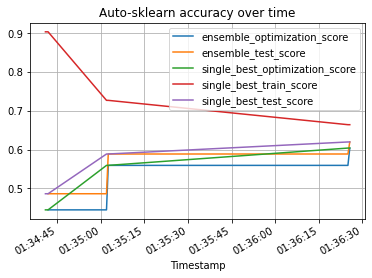

In [165]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [166]:
poT2 = poT 